## Capstone Project - Battle of Neighborhoods 

### Applied Data Science Capstone by IBM/Coursera

## Contents

* [Introduction : Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The aim of the project is to identify venues in **Bengaluru**, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Chandigarh, India, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data <a name="data"></a>

To begin with, we will take a look at Bengaluru on the Map using the folium library.

We will also fetch the data from two different APIs.

* Foursquare API: We will use the Foursquare API to fetch venues in Bengaluru within 4 Kilometers radius from the center of the city
* Zomato API: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [1]:
BLR_LATITUDE = 12.9716
BLR_LONGITUDE = 77.5946
print('The geograpical coordinates of Bangalore are {}, {}.'.format(BLR_LATITUDE, BLR_LONGITUDE))

The geograpical coordinates of Bangalore are 12.9716, 77.5946.


We will use the folium library to create a complete map zoomed on Bengaluru. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

In [2]:
import folium

bengaluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 14)
folium.Marker([BLR_LATITUDE, BLR_LONGITUDE]).add_to(bengaluru_map)
bengaluru_map

## Foursquare API

We begin by fetching a total of all venues in Bengaluru within a radius of 4 Kilometers from the center of Bengaluru using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [3]:
FOURSQUARE_CLIENT_ID = 'V3VGS25ZAJRLQ5IOYYCH1QZRIVRDCTRJW4DJVZK3RSNVFDR4'
FOURSQUARE_CLIENT_SECRET = 'MTRREK0SR5RDFHXW3TDPKMWTLSYFY3DQAD2FAQZ2ACGJUMEV'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20200629'

We define the get_category_type method to get the correct category for each venue.

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
* We will set the radius as 4 Kilometers.
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

In [6]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        BLR_LATITUDE, 
                                                                        BLR_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = pd.json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 100 venues fetched within a total radius of 4.0 Km
Total 35 venues fetched within a total radius of 4.0 Km

Total 235 venues fetched


### Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [7]:
headers = {'user-key': '509b17e908fa22e7ce3ac907795c9de2'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [8]:
bengarluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(bengaluru_map)  

bengaluru_map

We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [9]:
bengaluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(bengaluru_map)  

bengaluru_map.save('Maps/Venues by Zomato.html')
bengaluru_map

To combine the two datasets, we have to check that the latitude and longitude values of each corresponding venue match. We can round both the latitude and longitude values up to 4 decimal places. Then, we calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [10]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [11]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [12]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues.head()

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,JW Marriott Hotel Bengaluru,Hotel,12.9724,77.5951,Merak-JW Marriott Hotel,12.9724,77.5951,1200.0,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",0.0000,0.0000
1,UB City,Shopping Mall,12.9717,77.5959,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",0.0001,0.0000
2,Toscano,Italian Restaurant,12.9720,77.5961,Toscano,12.9719,77.5964,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",-0.0001,0.0003
3,Smoke House Deli,Deli / Bodega,12.9717,77.5983,Smoke House Deli,12.9717,77.5983,1600.0,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",0.0000,0.0000
4,Shiro,Japanese Restaurant,12.9719,77.5962,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",-0.0001,-0.0003


In [13]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [14]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0
1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0
2,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0
3,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0
4,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0


In [15]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))
selected_venues.head()

Total venues available: 137


,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0
1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0
2,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0
3,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0
4,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Bengaluru based on their rating and average costs. This would enable any visitor to identify the venues they would want to visit based on their rating and cost preference.

In the first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information within a radius of 4 Km from the center of the Bengaluru city. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

We then explored the data retrieved from the two APIs on the map and identify the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

In [16]:
count_categories = selected_venues['categories'].value_counts()
count_categories

Indian Restaurant                28
Ice Cream Shop                    9
Café                              7
Hotel                             7
Snack Place                       5
Middle Eastern Restaurant         4
Coffee Shop                       4
Chinese Restaurant                4
Bakery                            4
Fast Food Restaurant              3
Brewery                           3
Seafood Restaurant                3
BBQ Joint                         3
Tea Room                          3
Dessert Shop                      2
Breakfast Spot                    2
Shopping Mall                     2
Sandwich Place                    2
Steakhouse                        2
Lounge                            2
Pub                               2
Department Store                  2
Italian Restaurant                2
Sushi Restaurant                  1
Pizza Place                       1
Juice Bar                         1
Bistro                            1
Afghan Restaurant           

<BarContainer object of 55 artists>

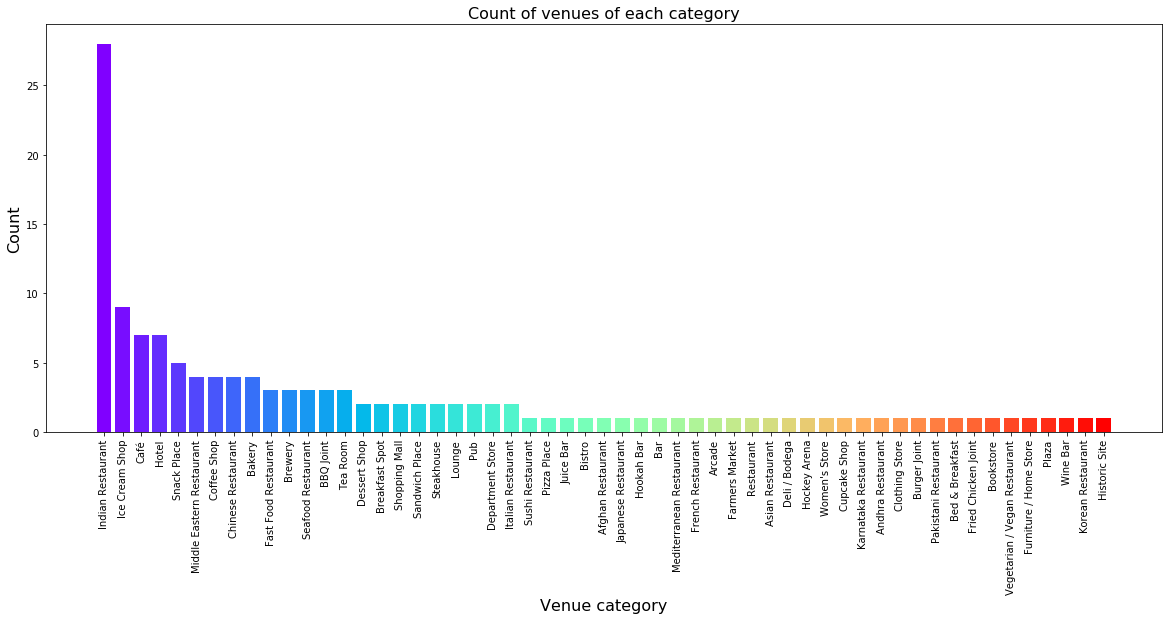

In [17]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 7.5))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

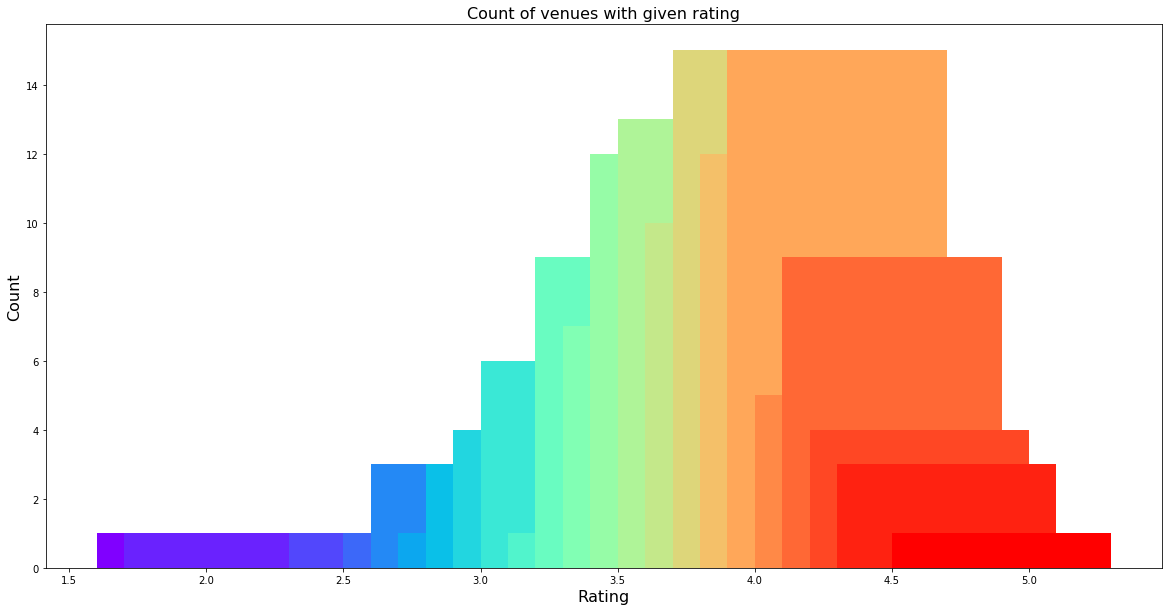

In [18]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 10))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [19]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [20]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

bengaluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(bengaluru_map)  
    
bengaluru_map

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

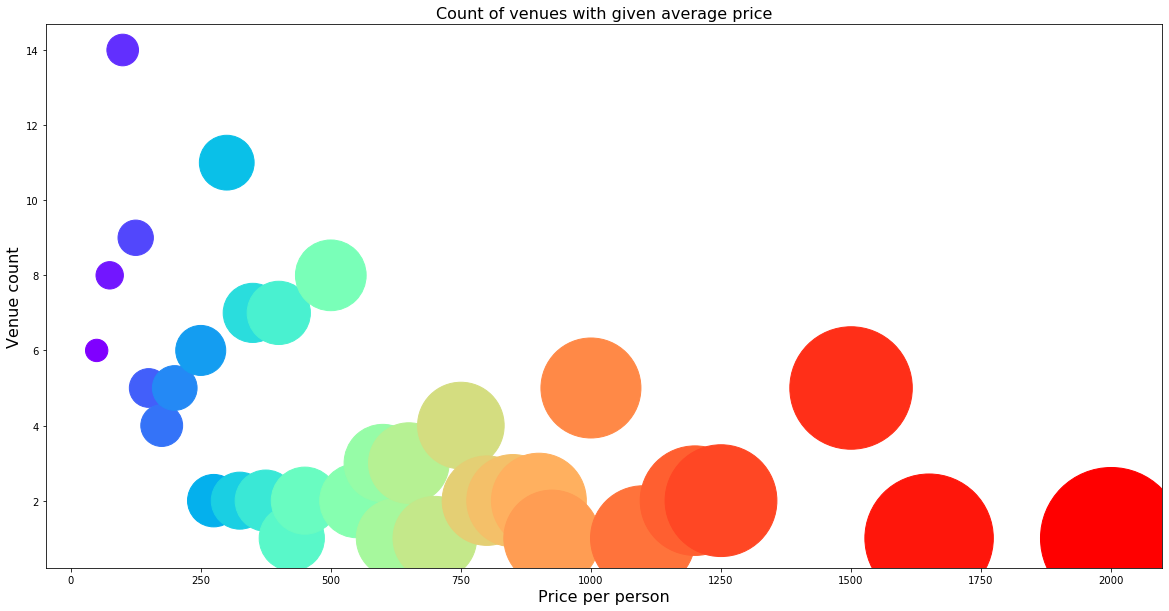

In [21]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 10))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [22]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

bengaluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(bengaluru_map)  

bengaluru_map

### Clustering 
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into three separate groups.

In [23]:
from sklearn.cluster import KMeans

k = 3

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = k, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0,Good
1,1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
2,1,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0,Very good
3,2,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0,Very good
4,1,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good


In [24]:
selected_venues.head(12)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0,Good
1,1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
2,1,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0,Very good
3,2,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0,Very good
4,1,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
5,2,French Restaurant,Cafe Noir,12.9721,77.5964,3.0,4.3,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",750.0,Very good
6,1,Lounge,Skyye,12.9716,77.5964,4.0,4.4,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good
7,1,Cupcake Shop,Skyye,12.9716,77.5964,4.0,4.4,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good
8,2,Sushi Restaurant,Harima,12.9675,77.5999,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,...",1000.0,Very good
9,2,Burger Joint,Mainland China,12.9715,77.6009,3.0,4.1,"15/16, Ground Floor, House of Lords, St. Marks...",850.0,Very good


## Results and Discussion <a name="results"></a>

The K means clustering with k=3 partitioned the venues into 3 clusters as shown in the below figure. Each dot representing a venue and similar color dots represents a cluster.

In [26]:
bengaluru_map = folium.Map(location = [BLR_LATITUDE, BLR_LONGITUDE], zoom_start = 12)
color_map = { 0: 'green', 1: 'yellow', 2: 'orange'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(bengaluru_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(bengaluru_map)
    
bengaluru_map.save('Maps/clusters.html')
bengaluru_map

In [27]:
cluster_0 = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
cluster_0.head().reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Ice Cream Shop,Corner House Ice Cream,12.9732,77.6000,1.0,4.3,"4, Madras Bank Road, Lavelle Road, Bangalore",175.0,Very good
1,0,Ice Cream Shop,Natural Ice Cream,12.9714,77.6010,1.0,4.2,"20, Ground Floor, 15/16, House Of Lords, St. M...",100.0,Very good
2,0,Fried Chicken Joint,Kentacky Chicken Corner,12.9662,77.5951,1.0,4.1,"10, Sampangi Tank Road, Richmond Road, Bangalore",150.0,Very good
3,0,Plaza,Lakeview Milkbar,12.9760,77.6038,2.0,3.9,"89, Kannan Building, MG Road, Bangalore",250.0,Good
4,0,Lounge,Cafe Coffee Day,12.9757,77.6053,2.0,2.9,"84, Ground Floor, Barton Centre, MG Road, Bang...",350.0,Okay


<BarContainer object of 34 artists>

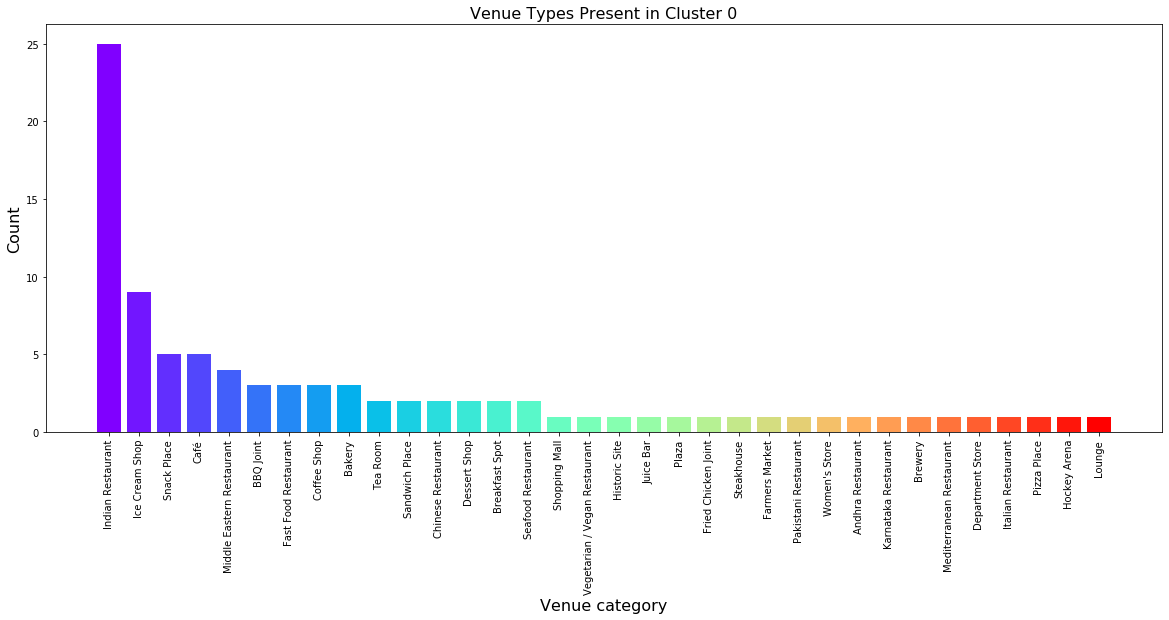

In [28]:
venue_distribution = cluster_0['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 7.5))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venue Types Present in Cluster 0", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In [29]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(cluster_0['price_range'].mean(), cluster_0['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.44 and rating spread around 3.84


In [30]:
cluster_1 = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
cluster_1.head().reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
1,1,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0,Very good
2,1,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
3,1,Lounge,Skyye,12.9716,77.5964,4.0,4.4,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good
4,1,Cupcake Shop,Skyye,12.9716,77.5964,4.0,4.4,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good


<BarContainer object of 10 artists>

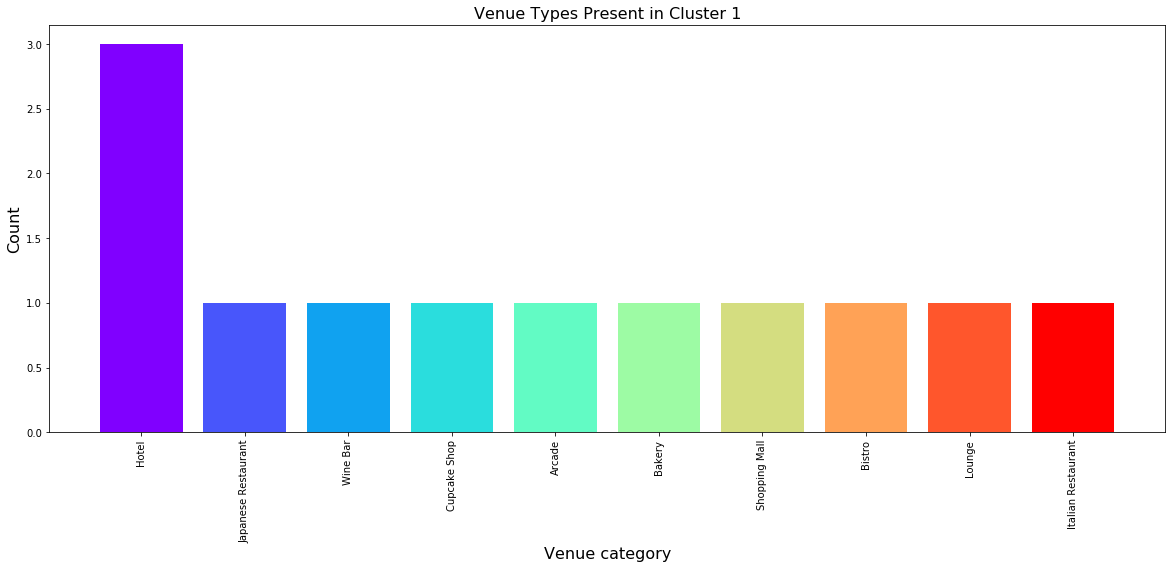

In [31]:
venue_distribution = cluster_1['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 7.5))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venue Types Present in Cluster 1", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In [32]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(cluster_1['price_range'].mean(), cluster_1['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 4.19


In [33]:
cluster_2 = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
cluster_2.head().reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0,Good
1,2,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0,Very good
2,2,French Restaurant,Cafe Noir,12.9721,77.5964,3.0,4.3,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",750.0,Very good
3,2,Sushi Restaurant,Harima,12.9675,77.5999,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,...",1000.0,Very good
4,2,Burger Joint,Mainland China,12.9715,77.6009,3.0,4.1,"15/16, Ground Floor, House of Lords, St. Marks...",850.0,Very good


<BarContainer object of 25 artists>

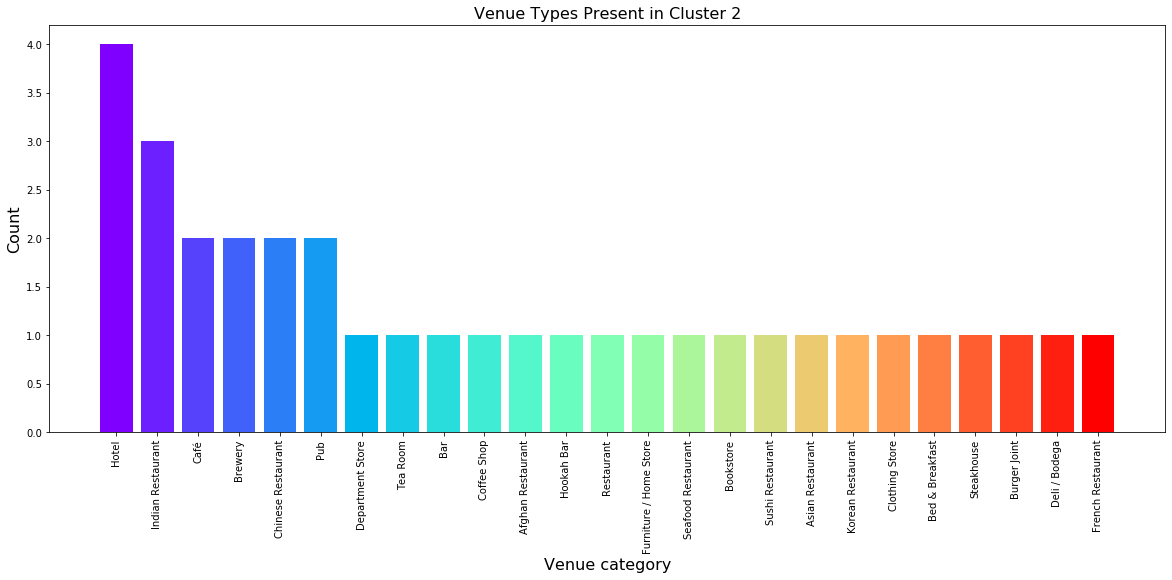

In [34]:
venue_distribution = cluster_2['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 7.5))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Venue Types Present in Cluster 2", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In [ ]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(cluster_2['price_range'].mean(), cluster_2['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 3.15 and rating spread around 4.11


## Conclusion <a name="conclusion"></a>

In this project we explored different venues and predicted most dominant types of venues within 4km radius from the center of Bengaluru city. Using Foursquare API and Zomato API we obtained location data for different types of venues, their types, ratings and average price.

The venues have been partitioned into 3 different clusters based on their price range and ratings using K means clustering algorithm and have been on a map. This analysis can be helpful for any person trying to find a suitable place for them when visiting the city. Any organization can use this information and build a website or mobile application and provide its users with updated information about carious venues in the city based on the search criteria (name, price, ratings) of its users. 